# Doomed to failure: A story about target encoding and Tree-Based Algorithms
---

Have you ever worked with target encoders? Did you ever use any tree-based model? If you have worked with either there will likely be a time in which you are tempted to use both in the same pipeline for classifying data points with categorical features. DON'T! At least until you have read this article detailing one dangerous caveat that this combination has.

In this article, I will guide you through the caveats that appear when a pipeline combines certain members of the family of target encoders with tree-based models and extremely low or high entropy features. I'll clue you in: data leakeages and overfitting issues will break your pipeline's performance.

The discussion will be centered around the most basic target encoder and the leave-one-out encoder and their interaction with tree-based models under certain conditions. Ultimately, it will lead towards a justification to use CatBoost under these same conditions.

The good news is that these problems that we will see are easy to solve - just use CatBoost and let it handle the encoding methodology for you. As I will be arguing the encoder that it uses by default for categorical features magnificently handles categorical fetures with both extremely low and high entropies and is still in the realm of target encoding.

**Important: to simplify the discussion we will frame the discussion under a binary classification task.**

### Table of Contents

1. Background
   - Encoders
   - Target Encoders
   - Leave-one-out Encoder

2.  Mixing Tree-based Models and Target Encoders: Failure Scenarios
   - Scenario 1: Leave-one-out Encoder + feature with a highly frecquent category that is uncorrelated to the target variable + Decision Tree -> Data Leak
   - Scenario 2: Target Encoder + feature with a large set of unique categories that have low frequency + Decision Tree -> Data Leak

3. The Solution: The Catboost Classifier and its encoding methodology

4. Conclusion

#### Package Imports

In [1]:
import random

import category_encoders as ce
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline

## Background Knowledge

### Encoders

Encoding methodologies aim to transform non-numerical categorical feature values into numerical values. There are multiple approaches and each comes with its own advantages and caveats. For instance, to mention a few of them:

- **Label Encoding**: it simply assigns a unique integer to each category in the data.
    *Pros:*
    1. Simple

    *Cons:*
    1. May introduce ordinal relationships
    2. Features with unknown amounts of categories which have high amounts of low-frecquency categories may be clustered into a marginal category, loosing predictive power based on them.

- **One-Hot Encoding**: for each category seen for a feature, it creates a new dummy feature which simply indicates with 0 or 1 when the category appears.
    *Pros:*
    1. Simple
    2. Does not assume order between categories

    *Cons:*
    1. Dimensionality may increase considerably making the use of a dimensionality reduction technique necessary and potentially exploding your system's memmory (tip: if you still want to use it check sparse matrices).
    2. Computationally expensive.
    3. Features with unknown amounts of categories which have high amounts of low-frecquency categories may be clustered into a marginal category, loosing predictive power based on them.

- **Binary Encoding, Hashing Encodings and more. Let's not get carried out into an endless enumeration.**

Importantly, encoding methodologies and classifier interact in different ways and consequently the resulting pipelines may inherit or develop different properties and caveats. 

### Target Encoders

In its most basic form, a target encoder substitutes each category $c$ of a feature with the training set statistic 
$$stat = \frac{N_{positive\_samples\_with\_category\_c\_for\_the\_feature}}{N_{all\_samples\_with\_category\_c\_for\_the\_feature}}$$

Let us see this basic encoder in action with a basic custom implementation. Firstly, we create a trivial dataset:

In [2]:
dataset_1 = pd.DataFrame(
    {
        "feature_1": ["A", "A", "A", "B", "B", "C"],
        "target": [0, 1, 0, 1, 0, 1],
    }
)
dataset_1

,feature_1,target
0,A,0
1,A,1
2,A,0
3,B,1
4,B,0
5,C,1


Then, we implement the encoding of the categories according to the most basic target encoder:

In [3]:
categories = dataset_1.feature_1.unique()
stats_map = {
    category: dataset_1[dataset_1.feature_1 == category].target.mean() for category in categories
}
dataset_1["feature_1_encoded"] = dataset_1.feature_1.map(stats_map)
dataset_1

,feature_1,target,feature_1_encoded
0,A,0,0.333333
1,A,1,0.333333
2,A,0,0.333333
3,B,1,0.500000
4,B,0,0.500000
5,C,1,1.000000


The resulting encoded feature is the only one used by ML algorithms. The idea is that we can actually encode features by their tendency to be associated with the positive class. This way an algorithm learns on top of the tendencies seen for all features, "weights" them and is able to generalize on nobel data points

Nevertheless, note that the encoded value for C has quite a strong meaning taking into account that we have only one instance of it (I know: the other categories are nearly as scarce from the statistical perspective). In other words, C could actually be a lucky sample and in reality C could actually be more associated with zero labels. Good catch! Actually, this first encoder comes with its own caveat: it is easy to overfit based on scarce categories. 

Therefore, many versions arised to distill this knowledge about category frecquency into the encodings. The most common approach is to simply perform a smoothing between the prior prevalence computed over the training set and the target statistic. For instance, the target encoding from the category-encoders library uses the smoothing:
$$enc(category) = p * stat + (1 - p) * prevalence$$
where the prevalence is defined by:
$$prevalence = \frac{N_{positives}}{N}$$
and the weighting constant is obtained by:
$$p = \frac{1}{1 + \exp\big(\frac{(-n\_{value} - k)}{f}\big)}$$
In the last equation, $k$ and $f$ are respectively called the minimum samples per leaf and smoothing parameters. To get further information checkout their [documentation](https://contrib.scikit-learn.org/category_encoders/targetencoder.html).

#### Leave-one-out Encoder

As previously mentioned, there are multiple types of target encoders and sometimes different resources name them differently. However, the last encoder in the previous section is usually the one receiving the name of target encoder. An encoder in this big family that is commonly used is the so-called leave-one-out Encoder. The methodology that it uses aims to signal outlier category-to-label instances and reduce their impact in the general target statistic computation. It is frequently used by data scientists. As we will see it comes with several caveats. However, let us see how it works first!

The leave-one-out encoder is actually a vanila target encoder. However, it has a slight modification: it works differently when fitting and transforming the encoder to the training data in comparison when it transforms data from the validation or test sets and new inference data. That is:

- When fitting and transforming training data: to compute the encoding of a category c for sample i, we compute the target statistic without accounting for the ith sample
- When transforming data once the encoder has been fitted, the encoder works as the most basic vanila target encoder.

The goal of this approach is to ensure that the classifier can learn about categories during training without the encodings being too influenced by outliers. Up next, we show how it works for our dummy dataset while simultaneously comparing it with the target encoder.

In [4]:
target_encoder = ce.TargetEncoder()
loo_encoder = ce.LeaveOneOutEncoder()

If we look at the resulting transformation performed by the leave-one-out encoder on the training set (done with the **fit_transform** method) we see the following:

In [5]:
loo_encoder.fit_transform(dataset_1[["feature_1"]], dataset_1["target"])

,feature_1
0,0.5
1,0.0
2,0.5
3,0.0
4,1.0
5,0.5


whereas transformation that it does for any dataset that are passed once it is fitted (only calling the **transform** method) are different since the leaving-one-out methodology is no longer applied:

In [6]:
loo_encoder.transform(dataset_1[["feature_1"]])

,feature_1
0,0.333333
1,0.333333
2,0.333333
3,0.500000
4,0.500000
5,0.500000


Note the following three things:

1. Category C only appears once, and consequently we do not want its encoding to be highly influential during training. The leaving-one-out methodology achieves this by simply substituting C with the prevalence of the training data since by leaving it out, we do not have any sample to compute the target statistic and consequenly default to the prevalence: 0.5.

2. The outlier sample in terms of the category-to-target relationship for category A was encoded differently during training i.e. it was replaced by 0 instead of 0.5.

3. Indeed the encoder transforms categories differently once it has been fitted (actually, if you think about it: it is impossible to run the leaving-one-out methodology on inference data since you do not the label).

You may also notice another fact: feature_1 kind of sucks in order to predict target labels from it. It's okay, we only want to use this dummy dataset to show the inner workings of these encoders.

To demonstrate the third point, we can see that the target encoder indeed always performs the same encoding:

In [7]:
target_encoder.fit_transform(dataset_1[["feature_1"]], dataset_1["target"])

,feature_1
0,0.474256
1,0.474256
2,0.474256
3,0.500000
4,0.500000
5,0.565054


In [8]:
target_encoder.transform(dataset_1[["feature_1"]])

,feature_1
0,0.474256
1,0.474256
2,0.474256
3,0.500000
4,0.500000
5,0.565054


## Mixing Tree-based Models and Target Encoders: Failure Scenarios

> *A smooth sea never made a skilled sailor*

At this point you have read through the definitions of the vanila target encoder and the leave-one-out encoder, and might be tempted to start using it with powerfull tree-based classifiers like Random Forests. ⚠️WATCH OUT!⚠️ As you will see in the following set of scenarios, under certain conditions this combination can be fatal and lead to the massive overfitting of the training dataset.

These are basically two scenarios: 

- Scenario 1: Leave-one-out Encoder + feature with a highly frecquent category that is uncorrelated to the target variable + Decision Tree -> Data Leak

- Scenario 2: Target Encoder + feature with a large set of unique categories that have low frequency + Decision Tree -> Data Leak 


### Scenario 1: Leave-one-out Encoder + feature with a highly frecquent category that is uncorrelated to the target variable + Decision Tree

To showcase this failure scenario, we will use a new dummy dataset which contains only one feature and the target. For your information, this feature will always have the same categorical value and consequently the target random variable and the feature random variable are independent. In fact, this means that you can't use that feature to make that prediction and that you might need to collect new features. 


In [9]:
dataset_2 = pd.DataFrame(
    {
        "independent_feature": ["a"] * 10,
        "target": [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    },
)
dataset_2

,independent_feature,target
0,a,0
1,a,1
2,a,0
3,a,1
4,a,0
5,a,1
6,a,0
7,a,1
8,a,0
9,a,1


It is clear that this feature has a category $a$ which not only is uncorrelated but also is highly frecquent. The problem that appears from having this kind of features when using the leave-one-out encoder and a tree-based model appears when during training, the leave-one-out methodology leaks information about the target variable into the encodings of the feature. 

We can illustrate why this happens with the above dataset. The reason is that if we have n samples with category a and out of these there are m samples that have a target of 1, then if we are encoding the category of a sample with target 1, then we get the statistic: $$\frac{m-1}{n-1}$$ whereas if the sample is associated with label 0 then we get the statistic: $$\frac{m}{n-1}$$

Therefore, the encoding itself is somehow copying all the information about the target variable needed to correctly predict on all samples from the training set. As a mater of fact, we can see that this happens for our dataset:

In [10]:
loo_encoder = ce.LeaveOneOutEncoder()
encoded_dataset_2 = loo_encoder.fit_transform(dataset_2[["independent_feature"]], dataset_2["target"])
encoded_dataset_2


,independent_feature
0,0.555556
1,0.444444
2,0.555556
3,0.444444
4,0.555556
5,0.444444
6,0.555556
7,0.444444
8,0.555556
9,0.444444


It is no mistery that a simple decision tree can the perfectly fit the training dataset since it is able to build a hyperplane separating both encodings. 
As a matter of fact: 

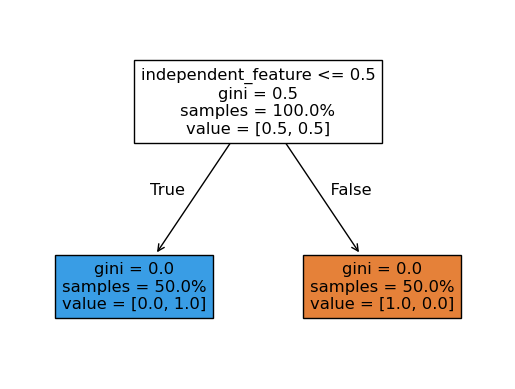

In [11]:
tree = DecisionTreeClassifier().fit(encoded_dataset_2, dataset_2["target"])
figure = plot_tree(
    tree,
    proportion=True,
    filled=True,
    feature_names=["independent_feature"],
)

which shows a perfect fit on the training set even though we know that since the feature and the target are independent this tree would then yield poor results for newly sampled data points. Note that this is a perfect fit since the gini impurity of all leaf nodes is 0.

Why not just drop the feature and use others in the data set? I mean: Shouldn't this feature be dropped on the EDA part of the project? Well the answer is that this example is exagerating the presence of the category and consequently its impact. Nevertheless, this impact still happens for milder instances of this same scenario. For instance, if we have that a feature has for 80% of the training data the same categorical value which is uninformative about the target variable, then this phenomenon will happen but only affect this 80% of the dataset. However, if it turns out that for the rest of the dataset the same happens for another feature, then we are doomed to failure as well.

Notice that this would not happen for other encoders. Nevertheless all projects are unique and their particularities may also yield other encoders useless. Hence, it is good to know that we can still use this kind of encoders (we will show it in the future). Additionally, even though it is highly not recommended you might not have information about all the possible features that you can have in the training data but you may still want to use as much information as you can while delegating the triage of useless and usefull features to your encoder + classifier pipeline. Again, although this can happen I would not recommend it since you may incur in unexpected errors. 

### Scenario 2: Target Encoder + feature with a large set of unique categories that have low frequency + Decision Tree -> Data Leak


The dataset that we will use to showcase this failure scenario contains a feature *name* that has a large set (with respect to the total size of the training dataset) of unique categories with low frequency. As a matter of fact, this feature does not give any information about the true target value of samples since it has a role similar to that of an indexer. Hence, we should not be able to predict based on it. Additionally, we have created a truly meaningfull feature *is_known_worldwide* which would allows us to learn a model capable of generalizing.

Let us have a look at this dataset (as you can see when I was working on this topic the presidential elections in the USA were running):

In [12]:
dataset_3 = pd.DataFrame(
    {
        "name": ["Trump", "Obama", "Biden", "Sanders", "Kamala", "Musk", "Guillermo del Toro"],
        "is_known_worldwide": [True, True, True, False, False, True, False],
        "target": [1, 1, 1, 0, 0, 0, 0],
    },
)
dataset_3

,name,is_known_worldwide,target
0,Trump,True,1
1,Obama,True,1
2,Biden,True,1
3,Sanders,False,0
4,Kamala,False,0
5,Musk,True,0
6,Guillermo del Toro,False,0


The aforementioned feature, *name*, does indeed have a similar role as the one of an idex for our training data i.e. each sample has a unique value for it. As a matter of fact it is this property the one that allows a pipeline based on a Target Encoder and a tree-base model as simple as a Decision Tree to overfit the training data due to a data leak from the target variable.

The reason for this leak is that when computing the encodings of the categories for *name*, we have that even with the smoothing we get only two values:

- For samples with target value equal to 1, we get:

$$p*prevalence + (1-p)*1$$

- For samples with target value equal to 0, we get:

$$p*prevalence$$

Therefore, we get an encoding which contains the information about the target values for each sample. In our case, the target encoding yields:

In [13]:
target_encoder = ce.TargetEncoder(cols=["name", "is_known_worldwide"])
encoded_data_3 = target_encoder.fit_transform(
    dataset_3[["name", "is_known_worldwide"]], dataset_3["target"]
)
encoded_data_3

,name,is_known_worldwide
0,0.502919,0.482566
1,0.502919,0.482566
2,0.502919,0.482566
3,0.372811,0.362372
4,0.372811,0.362372
5,0.372811,0.482566
6,0.372811,0.362372


Again, it is no mistery that a decision tree can make a perfect fit of this dataset while only looking at the unmeaningfull feature: *name*. Have a look:

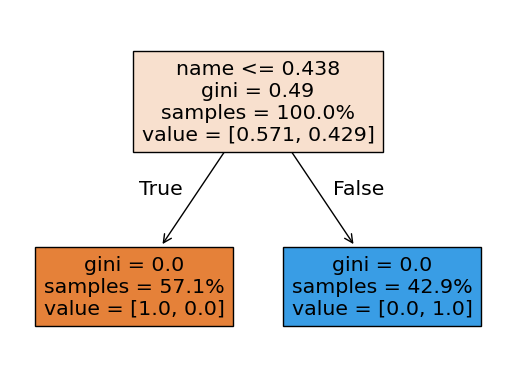

In [14]:
tree = DecisionTreeClassifier().fit(encoded_data_3, dataset_3["target"])
figure = plot_tree(
    tree,
    proportion=True,
    filled=True,
    feature_names=["name", "is_known_worldwide"],
)

Note once more that this is a perfect fit since the gini impurity of all leaf nodes is 0. 

Again, you could be asking why is this feature not dropped in the EDA part of the project after realizing it works as an indexer. However, you would be getting the same answer as beforehand: this example is exagerated, but this phenomenon can happen even if this column just works as an indexer for a part of the dataset while the rest has meaningfull information. Additionally, most of the arguments given for the same question in scenario 1 still apply for this scenario.

## The Solution: The Catboost Classifier and its encoding methodology

The Catboost classifier is a tree-based model of the family of gradient boosting algorithms which basically iteratively build a tree, compute the loss gradient function and approximate the gradient descent step by adding a tree that fits this loss gradient function to the original tree. These kinds of algorithms are known to be extremely powerfull and even state-of-the-art for tabular datasets.

However, Catboost has more features that amaze its users, and one of it is its encoding methodology. This methodology is in the family of target encoders, but elegantly solves the issues from the aforementioned failuer scenarios. It works as follows:

1. First of all, it permutes all samples in the training set before encoding them. In other words, it shuffles the dataset.

2. Next, it encodes the feature's category of row i ysing the target statistic computed over the previous rows.

In addition, each tree fitted by the catboost classifier uses a different encoding using a brand new permutation.

Why does it solve the aforementioned scenarios? Great question! The answer is clear:

- This methodology solves the issue in scenario 1 since now having a category with extremely high frequency and low correlation with the target variables does not leak the information about the label since the permutations and only encoding with previous rows ensure that each time we get different proportions of 1s.

- Regarding how it handles columns that behave similar to indexes, since the methodology looks at the previous rows, unique categories are encoded by the prevalence.

Let us build a dummy dataset with:

- A column which acts like an index: *city*.

- A column that is constant: *is_from_usa*.

- A correlated feature with the target variable: *right_wing*.

- The target variable.

In [40]:
number_of_rows = 10
interesting_column = [random.getrandbits(1) for _ in range(number_of_rows)]
modified = [int(not val) if random.random() < 0.15 else int(val) for val in interesting_column]
final_dataset = pd.DataFrame(
    {
        "city": [f"city_{index}" for index in range(number_of_rows)],
        "is_from_usa": [True]*number_of_rows,
        "right_wing": map(lambda x: "yes" if x else "no", interesting_column),
        "target": modified,
    },
)
final_dataset

,city,is_from_usa,right_wing,target
0,city_0,True,no,0
1,city_1,True,yes,1
2,city_2,True,no,0
3,city_3,True,no,0
4,city_4,True,no,0
5,city_5,True,no,0
6,city_6,True,no,0
7,city_7,True,no,0
8,city_8,True,yes,0
9,city_9,True,no,0


Next, we show how the catboost encoding methodology would work for one iteration i.e. using only one permutation to build one tree. The encoder that uses one permutation can be obtained from the Category Encoders package, and is the one that we will be using next. However, take into consideration that the effects of this methodology would be benefited from the multiple permutations when building different trees in the Catboost ensemble. That is, the integration of the encoding and modelling methodology that happens in the Catboost classifier further improves the response to the aforemntioned kinds of features.

Hence, here we will only show the effect with the simpler (one permutation) version of the catboost encoder and use a decision tree to fit the encoded data. This would be similar to training Catboost with one iteration.

In [41]:
catboost_encoder = ce.CatBoostEncoder(cols=["city", "right_wing", "is_from_usa"])
catboost_encoded_data = catboost_encoder.fit_transform(
    final_dataset.drop(columns=["target"], axis=1),
    final_dataset["target"],
)
catboost_encoded_data

,city,is_from_usa,right_wing
0,0.1,0.1,0.100000
1,0.1,0.1,0.100000
2,0.1,0.1,0.050000
3,0.1,0.1,0.033333
4,0.1,0.1,0.025000
5,0.1,0.1,0.020000
6,0.1,0.1,0.016667
7,0.1,0.1,0.014286
8,0.1,0.1,0.550000
9,0.1,0.1,0.012500


As we see this methodology has consequently succeded in both failure scenarios since now the two troublesome features have been appropiately encoded with the meaning that they provide: none. On the other hand, the meaningfull feature *right_wing* is encoded differently in what at first seems to be valuable for predicting the target variable.

Lets check whether a tree will be able to overfit on the training data now:

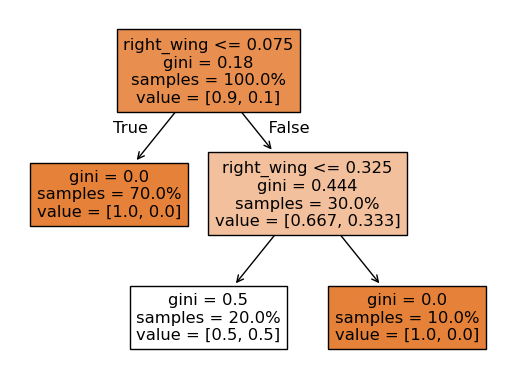

In [44]:
tree = DecisionTreeClassifier().fit(catboost_encoded_data, final_dataset["target"])
figure = plot_tree(
    tree,
    proportion=True,
    filled=True,
    feature_names=catboost_encoded_data.columns.tolist(),
)

Therefore, we have proved how this methodology is able to overcome the issues seen in the previous scenarios. That is, the catboost classifier now ignores constant or nearly constant uncorrelated features as well as those which behave similar to an index. In turn, the associated classifier can now focus on the important features for our target variable.

## Conclusion

If you want to use an encoder from the family of target encoders and a tree-base model, why don't you use directly Catboost?

Hope that you have enjoyed this article as much as I did when finding out about this issues!
Thanks for reading this far! Congrats!! Checkout my webpage for more articles on Machine Learning, AI, Cryptography or Mathematics.